# TIME SERIES ANALYTICS - CONSUMO ENERGIA ELÉTRICA

O objetivo dessa análise preditiva é prever o consumo de energia elétrica nos próximos 365 dias com o uso do algoritmo de séries temporais Prophet que foi feito pelo núcleo de ciência de dados do Facebook.

A fonte dos dados: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

## 1. Carga dos Pacotes

In [1]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib import pylab
from prophet import Prophet
from datetime import datetime
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Carga dos Dados

In [6]:
# Carregando os dados
base = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)
base.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 3. Pré-Processamento dos Dados

In [7]:
# Verifica o shape da base
# São 2 milhões registros e 9 atributos
base.shape

(2075259, 9)

In [8]:
# Resumo do dataset
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [26]:
# Verifica se há valores nulos
base.isnull().values.any()

True

In [27]:
# Contagem de valores nulos

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [28]:
# Remove registros nulos da base
# Pelo número de linas, confirmamos que houve a remoção dos valores nulos
base = dataset.iloc[0:, 2:9].dropna()

In [30]:
# Alguns valores na base estão como "?" e neste caso vamos substituir por 0
base = base.replace(to_replace = ['?'], value = [0])

In [31]:
# Confere os valores nulos novamente

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [24]:
# Converte coluna de data em DateTime
base['Date'] = pd.to_datetime(base["Date"])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [33]:
# Converte os demais atributos para tipo float64
base['Global_active_power'] = pd.to_numeric(base['Global_active_power'])
base['Global_reactive_power'] = pd.to_numeric(base['Global_reactive_power'])
base['Voltage'] = pd.to_numeric(base['Voltage'])
base['Global_intensity'] = pd.to_numeric(base['Global_intensity'])
base['Sub_metering_1'] = pd.to_numeric(base['Sub_metering_1'])
base['Sub_metering_2'] = pd.to_numeric(base['Sub_metering_2'])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Sub_metering_12                 float64
dtype: object

In [34]:
# Cria coluna com o consumo doméstico total
base['total_consumo'] = base['Sub_metering_1'] + base['Sub_metering_2'] + base['Sub_metering_3']

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Sub_metering_12                 float64
total_consumo                   float64
dtype: object

In [36]:
# Verifica a base de dados
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_12,total_consumo
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1.0,18.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1.0,17.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2.0,19.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1.0,18.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0,0.0
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0,0.0
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0,0.0
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0,0.0


In [37]:
# Cópia da base para análise exploratória
df = base

In [39]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df['year'] = df['Date'].dt.year

# Variável Mês
df['month'] = df['Date'].dt.month

#Variável Ano-Mês
df['month_year'] = df['Date'].dt.to_period('M')

In [40]:
# verifica os dados
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_12,total_consumo,year,month,month_year
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1.0,17.0,2006,12,2006-12
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2.0,19.0,2006,12,2006-12
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0,0.0,2010,11,2010-11


In [44]:
# Data como index da base
df = df.set_index('Date')
df.head()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_12,total_consumo,year,month,month_year
Date,,,,,,,,,,,,,
2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12
2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1.0,17.0,2006,12,2006-12
2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2.0,19.0,2006,12,2006-12
2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12
2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1.0,18.0,2006,12,2006-12


Text(0.5, 0, ' ')

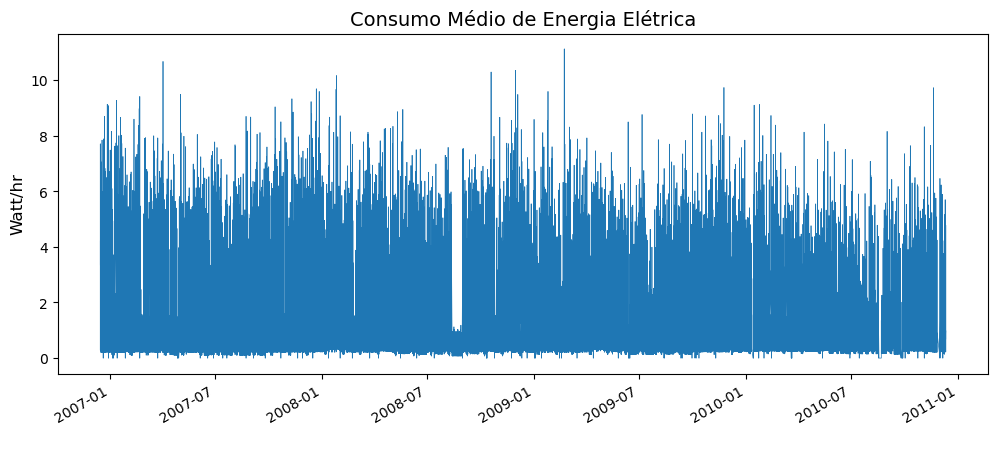

In [48]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['Global_active_power'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Médio de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)